# AI Project: Employee Attrition Prediction - **source code**

## Table of Contents
- [Framework](#framework)
- [Initial dataset](#initial-dataset)
- [Ethic](#ethic)
- [Data wrangling](#data-wrangling)
- [Model](#model)
  - [Implementation](#implementation)
  - [Quality indicators](#quality-indicators)
  - [Graph and observation](#graph-and-observation)


## Framework

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

sns.set(style='whitegrid')

## Initial dataset

little description of the data set

## Ethic

blabla ethic
What we delete

## Data wrangling

### Data importation

In [2]:
# Load data
general_df = pd.read_csv(os.path.join('data','general_data.csv'))
manager_survey_df = pd.read_csv(os.path.join('data', 'manager_survey_data.csv'))
employee_survey_df = pd.read_csv(os.path.join('data', 'employee_survey_data.csv'))
in_time = pd.read_csv(os.path.join('data', 'in_time.csv'))
out_time = pd.read_csv(os.path.join('data', 'out_time.csv'))

### Data observation before wrangling

In [3]:
# Check initial data sizes
print(f"General Data: {general_df.shape} (rows, columns)")
print(f"Manager Survey: {manager_survey_df.shape}")
print(f"Employee Survey: {employee_survey_df.shape}")


print("\n===========================================================\n")


# Check if EmployeeID has duplicates
if general_df['EmployeeID'].duplicated().sum() == 0:
    print("EmployeeID is unique")
else:
    print("Warning")


print("\n===========================================================\n")


# Merge data
merge_df = pd.merge(general_df, manager_survey_df, on='EmployeeID', how='left')
final_df = pd.merge(merge_df, employee_survey_df, on='EmployeeID', how='left')

print(f"Size of Final Table: {final_df.shape}")


print("\n===========================================================\n")


print(f"First 5 rows:")
display(final_df.head())

General Data: (4410, 24) (rows, columns)
Manager Survey: (4410, 3)
Employee Survey: (4410, 4)


EmployeeID is unique


Size of Final Table: (4410, 29)


First 5 rows:


,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,1.0,6,1,0,0,3,3,3.0,4.0,2.0
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,6.0,3,5,1,4,2,4,3.0,2.0,4.0
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,5.0,2,5,0,3,3,3,2.0,2.0,1.0
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,13.0,5,8,7,5,2,3,4.0,4.0,3.0
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,9.0,2,6,0,4,3,3,4.0,1.0,3.0


In [4]:
# Check initial data sizes
print(f"In time: {in_time.shape} (rows, columns)")
print(f"Out time: {out_time.shape}")

# Rename first column to 'EmployeeID' for consistency
in_time.rename(columns={in_time.columns[0]: 'EmployeeID'}, inplace=True)
out_time.rename(columns={out_time.columns[0]: 'EmployeeID'}, inplace=True)

# Set 'EmployeeID' as index
in_time.set_index('EmployeeID', inplace=True)
out_time.set_index('EmployeeID', inplace=True)

# Change data into datetime. errors='coerce' if (NaT)
in_time_df = in_time.apply(pd.to_datetime, errors='coerce')
out_time_df = out_time.apply(pd.to_datetime, errors='coerce')

# Calculate working time
working_time = out_time_df - in_time_df
display(working_time.head())


print("\n===========================================================\n")


# Check average working time
average_working_time = working_time.mean(axis=1)
avg_working_hours_numeric = average_working_time.apply(lambda x: x.total_seconds() / 3600)
display(avg_working_hours_numeric.head())


print("\n===========================================================\n")


# Reset index to turn Series into DataFrame
time_features_df = avg_working_hours_numeric.reset_index()
# Rename columns
time_features_df.columns = ['EmployeeID', 'AvgWorkingHours']
# Display final time features DataFrame
display(time_features_df.head())


print("\n===========================================================\n")


# Merge time features back to final_df
final_df = pd.merge(final_df, time_features_df, on='EmployeeID', how='left')
# Check final data sizes
print(f"Final DataFrame: {final_df.shape} (rows, columns)")


print("\n===========================================================\n")


print("First 5 rows of final DataFrame:")
display(final_df.head())

In time: (4410, 262) (rows, columns)
Out time: (4410, 262)


,2015-01-01,2015-01-02,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-12,2015-01-13,2015-01-14,...,2015-12-18,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-25,2015-12-28,2015-12-29,2015-12-30,2015-12-31
EmployeeID,,,,,,,,,,,,,,,,,,,,,
1,NaT,0 days 07:12:30,0 days 07:11:23,0 days 07:24:39,0 days 07:00:24,0 days 07:17:23,0 days 07:29:04,0 days 07:15:46,0 days 07:49:52,NaT,...,NaT,0 days 07:20:21,0 days 07:23:45,0 days 06:30:17,0 days 07:35:47,NaT,0 days 07:46:26,0 days 07:18:54,0 days 07:46:44,0 days 07:04:49
2,NaT,0 days 08:06:33,0 days 07:27:17,NaT,0 days 07:23:49,0 days 07:25:00,0 days 07:09:03,0 days 07:36:41,0 days 07:16:44,NaT,...,0 days 07:54:11,0 days 07:45:14,0 days 07:42:44,0 days 07:26:08,NaT,NaT,0 days 07:36:53,0 days 07:58:57,0 days 07:59:10,0 days 08:13:38
3,NaT,0 days 06:41:33,0 days 07:15:56,0 days 06:24:19,0 days 06:45:54,0 days 07:20:42,0 days 06:51:41,0 days 07:25:07,0 days 06:59:59,NaT,...,0 days 06:47:09,0 days 07:09:49,0 days 06:48:06,0 days 06:43:49,0 days 06:50:59,NaT,0 days 07:01:26,0 days 07:26:20,0 days 07:32:20,0 days 06:47:11
4,NaT,0 days 07:20:18,0 days 07:17:31,0 days 06:56:35,0 days 06:55:10,0 days 06:51:03,0 days 07:11:35,0 days 06:59:55,0 days 07:18:23,NaT,...,0 days 07:37:45,0 days 06:50:48,0 days 07:19:35,0 days 07:24:49,0 days 07:05:06,NaT,0 days 07:26:50,0 days 07:25:00,0 days 07:21:59,0 days 07:07:59
5,NaT,0 days 08:03:20,0 days 07:59:17,0 days 07:40:57,0 days 07:48:22,0 days 07:39:44,0 days 07:43:18,0 days 08:21:54,0 days 08:15:26,NaT,...,0 days 07:54:13,0 days 07:39:54,0 days 07:57:27,0 days 07:47:13,0 days 08:14:58,NaT,0 days 07:39:44,0 days 08:16:07,0 days 07:57:12,0 days 08:01:05


EmployeeID
1    7.373651
2    7.718969
3    7.013240
4    7.193678
5    8.006175
dtype: float64

,EmployeeID,AvgWorkingHours
0,1,7.373651
1,2,7.718969
2,3,7.013240
3,4,7.193678
4,5,8.006175




Final DataFrame: (4410, 30) (rows, columns)


First 5 rows of final DataFrame:


,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,AvgWorkingHours
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,6,1,0,0,3,3,3.0,4.0,2.0,7.373651
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,3,5,1,4,2,4,3.0,2.0,4.0,7.718969
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,2,5,0,3,3,3,2.0,2.0,1.0,7.013240
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,5,8,7,5,2,3,4.0,4.0,3.0,7.193678
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,2,6,0,4,3,3,4.0,1.0,3.0,8.006175


### Data cleaning

In [5]:
# Delete unneeded columns
columns_to_drop = ['EmployeeCount', 'Over18', 'StandardHours']
final_df.drop(columns=columns_to_drop, inplace=True)

# Handle missing values
numeric_columns = final_df.select_dtypes(include=[np.number]).columns
final_df[numeric_columns] = final_df[numeric_columns].fillna(final_df[numeric_columns].mean())

missing_values = final_df.isnull().sum()
print(missing_values)


print("\n===========================================================\n")


# Label encoding 
attrition_map = {'Yes': 1, 'No': 0}
final_df['Attrition'] = final_df['Attrition'].map(attrition_map)
gender_map = {'Male': 1, 'Female': 0}
final_df['Gender'] = final_df['Gender'].map(gender_map)
travel_map = {
    'Non-Travel': 0,
    'Travel_Rarely': 1,
    'Travel_Frequently': 2
}
final_df['BusinessTravel'] = final_df['BusinessTravel'].map(travel_map)
if 'MaritalStatus_Married' in final_df.columns:
    final_df.rename(columns={'MaritalStatus_Married': 'Married'}, inplace=True)

if 'MaritalStatus_Single' in final_df.columns:
    final_df.drop(columns=['MaritalStatus_Single'], inplace=True)

# One-hot encoding
categorical_columns = final_df.select_dtypes(include=['object']).columns
final_df = pd.get_dummies(final_df, columns=categorical_columns, drop_first=True)
final_df = final_df.replace({True: 1, False: 0})
print(final_df.info())
print("\n===========================================================\n")
print("First 5 rows after encoding:")
print("\n")
display(final_df.head())

print("\n===========================================================\n")

print(final_df.info())

# Standard data
final_df_scalled = final_df.copy()

scatter = StandardScaler()
final_df_scalled[numeric_columns] = scatter.fit_transform(final_df[numeric_columns])

Age                        0
Attrition                  0
BusinessTravel             0
Department                 0
DistanceFromHome           0
Education                  0
EducationField             0
EmployeeID                 0
Gender                     0
JobLevel                   0
JobRole                    0
MaritalStatus              0
MonthlyIncome              0
NumCompaniesWorked         0
PercentSalaryHike          0
StockOptionLevel           0
TotalWorkingYears          0
TrainingTimesLastYear      0
YearsAtCompany             0
YearsSinceLastPromotion    0
YearsWithCurrManager       0
JobInvolvement             0
PerformanceRating          0
EnvironmentSatisfaction    0
JobSatisfaction            0
WorkLifeBalance            0
AvgWorkingHours            0
dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 40 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                    

C:\Users\Louis\AppData\Local\Temp\ipykernel_34200\3991040890.py:36: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  final_df = final_df.replace({True: 1, False: 0})


,Age,Attrition,BusinessTravel,DistanceFromHome,Education,EmployeeID,Gender,JobLevel,MonthlyIncome,NumCompaniesWorked,...,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single
0,51,0,1,6,2,1,0,1,131160,1.0,...,0,0,0,0,0,0,0,0,1,0
1,31,1,2,10,1,2,0,1,41890,0.0,...,0,0,0,0,0,1,0,0,0,1
2,32,0,2,17,4,3,1,4,193280,1.0,...,0,0,0,0,0,0,1,0,1,0
3,38,0,0,2,5,4,1,3,83210,3.0,...,1,0,0,0,0,0,0,0,1,0
4,32,0,1,10,1,5,1,1,23420,4.0,...,0,0,0,0,0,0,1,0,0,1




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 40 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Age                                4410 non-null   int64  
 1   Attrition                          4410 non-null   int64  
 2   BusinessTravel                     4410 non-null   int64  
 3   DistanceFromHome                   4410 non-null   int64  
 4   Education                          4410 non-null   int64  
 5   EmployeeID                         4410 non-null   int64  
 6   Gender                             4410 non-null   int64  
 7   JobLevel                           4410 non-null   int64  
 8   MonthlyIncome                      4410 non-null   int64  
 9   NumCompaniesWorked                 4410 non-null   float64
 10  PercentSalaryHike                  4410 non-null   int64  
 11  StockOptionLevel                   4410 non-null   int

### **Ethical feature filtering**

In this section, we create two versions of the dataset:
- A full version with all features (no ethical filtering)
- An ethical version where we remove identifiers, sensitive columns, and redundant features

#### Columns considered sensitive / identifying / redundant

For ethical models, we remove:
- **Direct identifiers**: EmployeeID
- **Sensitive demographic data**: Gender, MaritalStatus
- **Education level and field**: Education, all EducationField_* columns
- **Number of companies worked**: NumCompaniesWorked


In [6]:
# Create full and ethical versions of the dataset

# Full dataset (no ethical filtering)
df_full = final_df_scalled.copy()

ethical_columns_to_drop = [
    'EmployeeID',                 # direct identifier
    'Gender',                     # gender
    'MaritalStatus_Married',      # marital status
    'MaritalStatus_Single',       # marital status
    'Married',                    # marital status (if renamed)
    'Education',                  # education level
    'NumCompaniesWorked'          # number of companies worked
]

# Find all EducationField columns (one-hot encoded)
education_field_cols = [col for col in final_df.columns if col.startswith('EducationField_')]
ethical_columns_to_drop.extend(education_field_cols)

# Ethical dataset with sensitive columns removed
df_ethical = final_df_scalled.drop(columns=ethical_columns_to_drop, errors='ignore')

print("Full dataset shape (all features):", df_full.shape)
print("Ethical dataset shape (reduced features):", df_ethical.shape)
print(f"\nRemoved columns for ethical dataset: {len(ethical_columns_to_drop)} columns")
print(f"\nNote: EmployeeID is kept in df_full but removed in df_ethical for ethical modeling")


Full dataset shape (all features): (4410, 40)
Ethical dataset shape (reduced features): (4410, 29)

Removed columns for ethical dataset: 12 columns

Note: EmployeeID is kept in df_full but removed in df_ethical for ethical modeling


### Data visualisation after wrangling

We explore the processed data with key plots showing relationships between features and attrition.

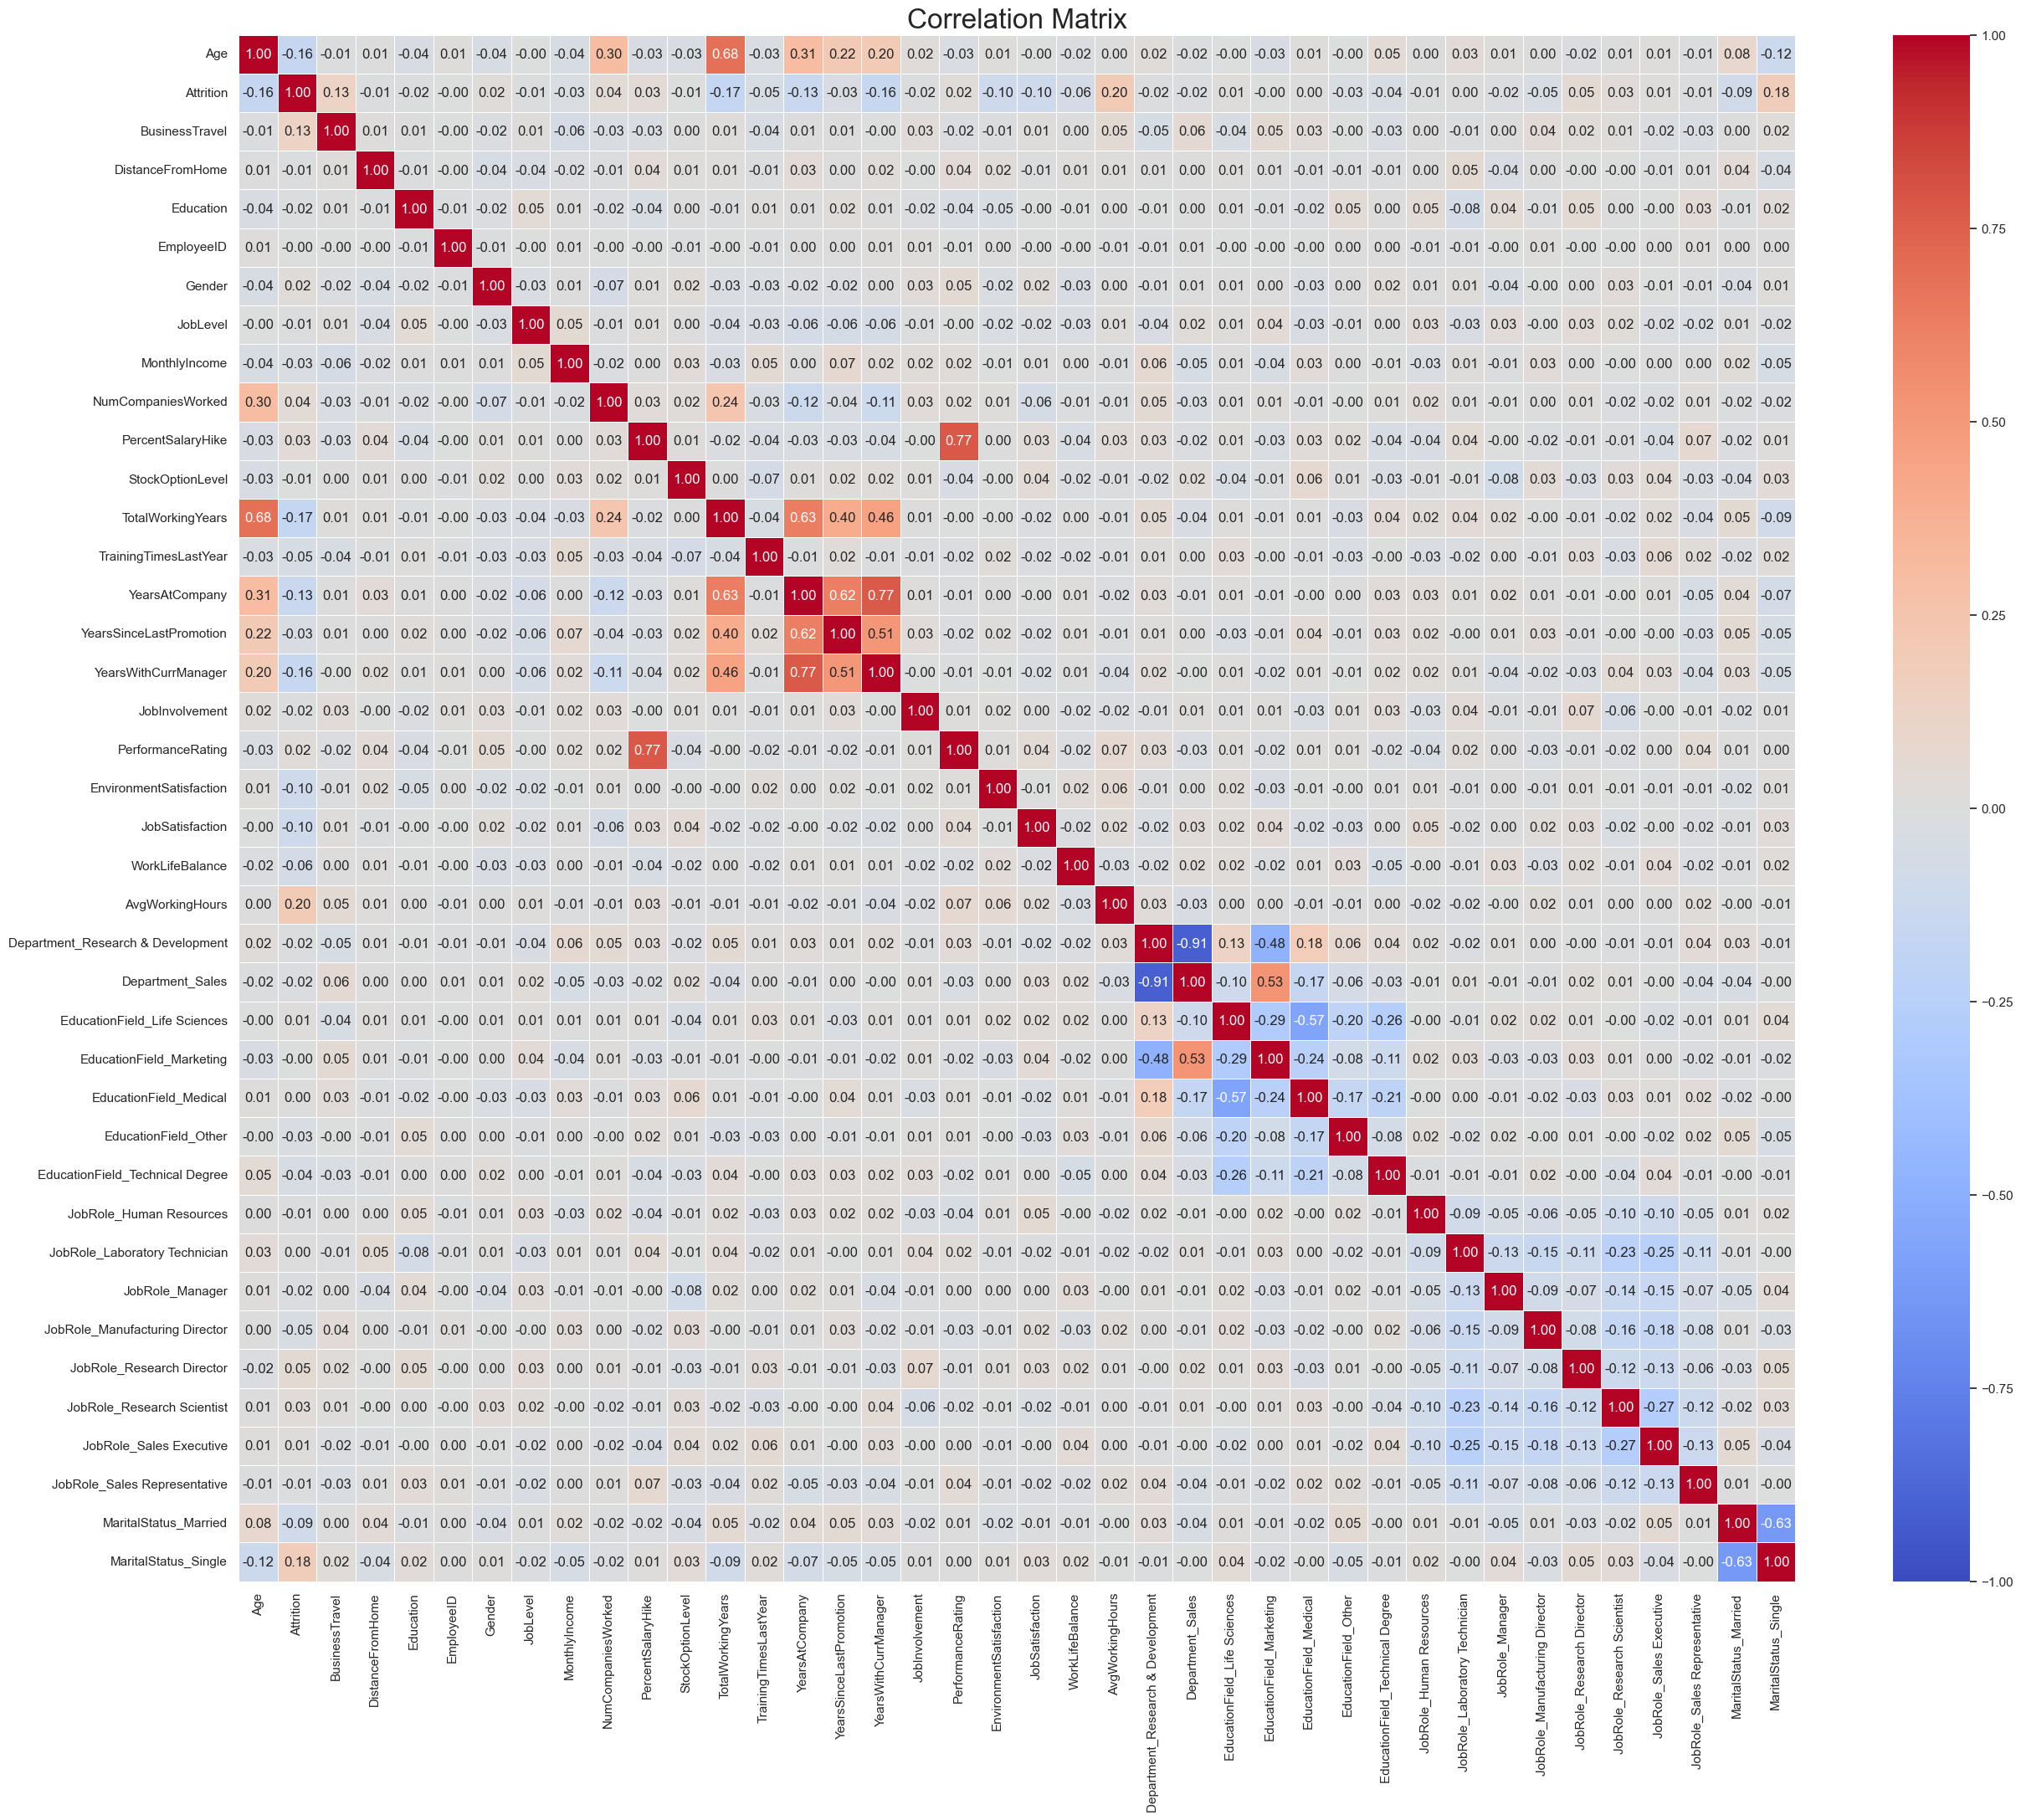

In [7]:
# Calculate correlation matrix
# Note: matplotlib and seaborn already imported in cell 3
corr_matrix = final_df.corr()

# Plot heatmap
plt.figure(figsize=(30, 24)) 
sns.heatmap(corr_matrix, 
            annot=True,       
            fmt=".2f",        
            cmap="coolwarm",  
            linewidths=0.5,   
            vmin=-1, vmax=1)  

plt.title("Correlation Matrix", fontsize=24)
plt.show()

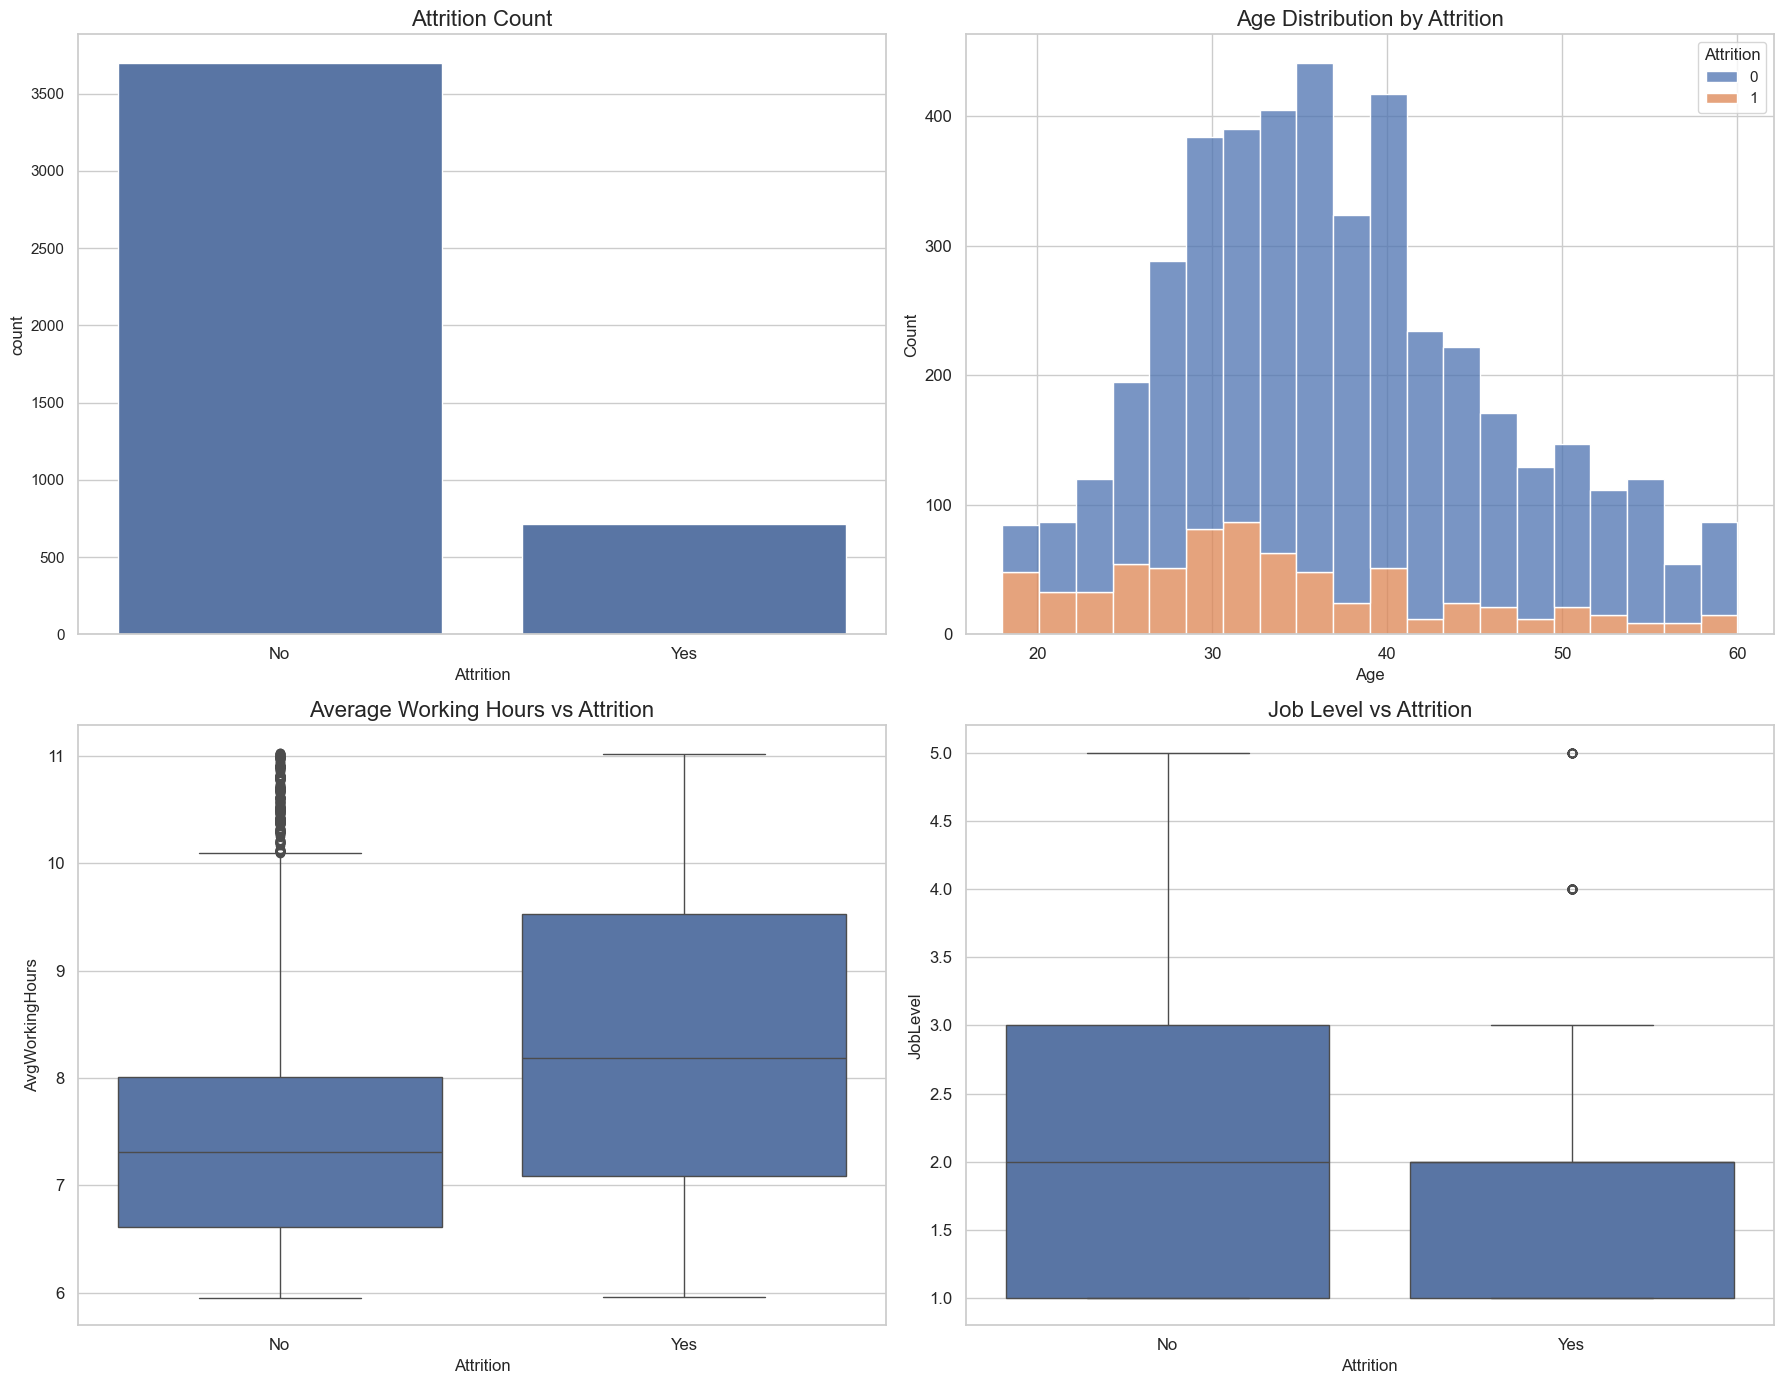

In [8]:
# Basic visualizations of attrition and key features

fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# 1. Attrition count
sns.countplot(data=final_df, x='Attrition', ax=axes[0, 0])
axes[0, 0].set_title('Attrition Count', fontsize=16)
axes[0, 0].set_xticks([0, 1])
axes[0, 0].set_xticklabels(['No', 'Yes'], fontsize=12)

# 2. Age distribution by attrition
sns.histplot(data=final_df, x='Age', hue='Attrition', multiple='stack', bins=20, ax=axes[0, 1])
axes[0, 1].set_title('Age Distribution by Attrition', fontsize=16)
axes[0, 1].tick_params(labelsize=12)

# 3. Average working hours by attrition
sns.boxplot(data=final_df, x='Attrition', y='AvgWorkingHours', ax=axes[1, 0])
axes[1, 0].set_title('Average Working Hours vs Attrition', fontsize=16)
axes[1, 0].set_xticks([0, 1])
axes[1, 0].set_xticklabels(['No', 'Yes'], fontsize=12)
axes[1, 0].tick_params(labelsize=12)

# 4. JobLevel vs attrition
sns.boxplot(data=final_df, x='Attrition', y='JobLevel', ax=axes[1, 1])
axes[1, 1].set_title('Job Level vs Attrition', fontsize=16)
axes[1, 1].set_xticks([0, 1])
axes[1, 1].set_xticklabels(['No', 'Yes'], fontsize=12)
axes[1, 1].tick_params(labelsize=12)

plt.tight_layout()
plt.show()


In [9]:
final_df.to_csv(os.path.join('data', 'final_data_processed.csv'), index=False)

In [10]:
target_col = 'Attrition'

# Attrition is already encoded (0/1) from earlier steps
X_full = df_full.drop(columns=[target_col])
y = df_full[target_col]

X_ethical = df_ethical.drop(columns=[target_col])

# Train/test split BEFORE scaling
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    X_full, y, test_size=0.2, random_state=42, stratify=y
)

X_train_eth, X_test_eth, y_train_eth, y_test_eth = train_test_split(
    X_ethical, y, test_size=0.2, random_state=42, stratify=y
)

print("Data standardization completed.")
print(f"Full features - scaled train/test: {X_train_full.shape}, {X_test_full.shape}")
print(f"Ethical features - scaled train/test: {X_train_eth.shape}, {X_test_eth.shape}")

Data standardization completed.
Full features - scaled train/test: (3528, 39), (882, 39)
Ethical features - scaled train/test: (3528, 28), (882, 28)


## Model

## Models with and without ethical constraints

We compare several models on:
- A full feature set (no ethical filtering)
- An ethical feature set (sensitive variables removed: EmployeeID, Gender, MaritalStatus, Education, EducationField, NumCompaniesWorked)

Models tested: Random Forest, Decision Tree, Naive Bayes, SVM


In [11]:
def evaluate_models(X_train, X_test, y_train, y_test, label):
    models = {
        'logistic_regresion': LogisticRegression(),
        'perceptron': Perceptron(),
        'random_forest': RandomForestClassifier(n_estimators=200, random_state=42),
        'decision_tree': DecisionTreeClassifier(random_state=42),
        'naive_bayes': GaussianNB(),
        'svm': SVC(probability=True)
    }

    print("\n" + "=" * 80)
    print(f"Results for feature set: {label}")
    print("=" * 80)

    trained_models = {}
    
    for name, model in models.items():
        print(f"\n--- {name} ---")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_test)[:, 1]
            auc = roc_auc_score(y_test, y_proba)
        else:
            auc = None

        print("Classification report:")
        print(classification_report(y_test, y_pred, digits=3))

        print("Confusion matrix:")
        print(confusion_matrix(y_test, y_pred))

        if auc is not None:
            print(f"ROC-AUC: {auc:.3f}")

        trained_models[name] = model

    return trained_models


# Evaluate on ethical feature set (using scaled data)
models_eth = evaluate_models(X_train_eth, X_test_eth, y_train_eth, y_test_eth, label='Ethical features')

# Evaluate on full feature set (using scaled data)
models_full = evaluate_models(X_train_full, X_test_full, y_train_full, y_test_full, label='Full features')



Results for feature set: Ethical features

--- logistic_regresion ---
Classification report:
              precision    recall  f1-score   support

           0      0.858     0.974     0.913       740
           1      0.548     0.162     0.250       142

    accuracy                          0.844       882
   macro avg      0.703     0.568     0.581       882
weighted avg      0.808     0.844     0.806       882

Confusion matrix:
[[721  19]
 [119  23]]
ROC-AUC: 0.778

--- perceptron ---
Classification report:
              precision    recall  f1-score   support

           0      0.874     0.916     0.894       740
           1      0.415     0.310     0.355       142

    accuracy                          0.819       882
   macro avg      0.644     0.613     0.625       882
weighted avg      0.800     0.819     0.808       882

Confusion matrix:
[[678  62]
 [ 98  44]]

--- random_forest ---
Classification report:
              precision    recall  f1-score   support

           

## ROC-AUC curves

We visualize ROC curves for all models on both ethical and full feature sets.


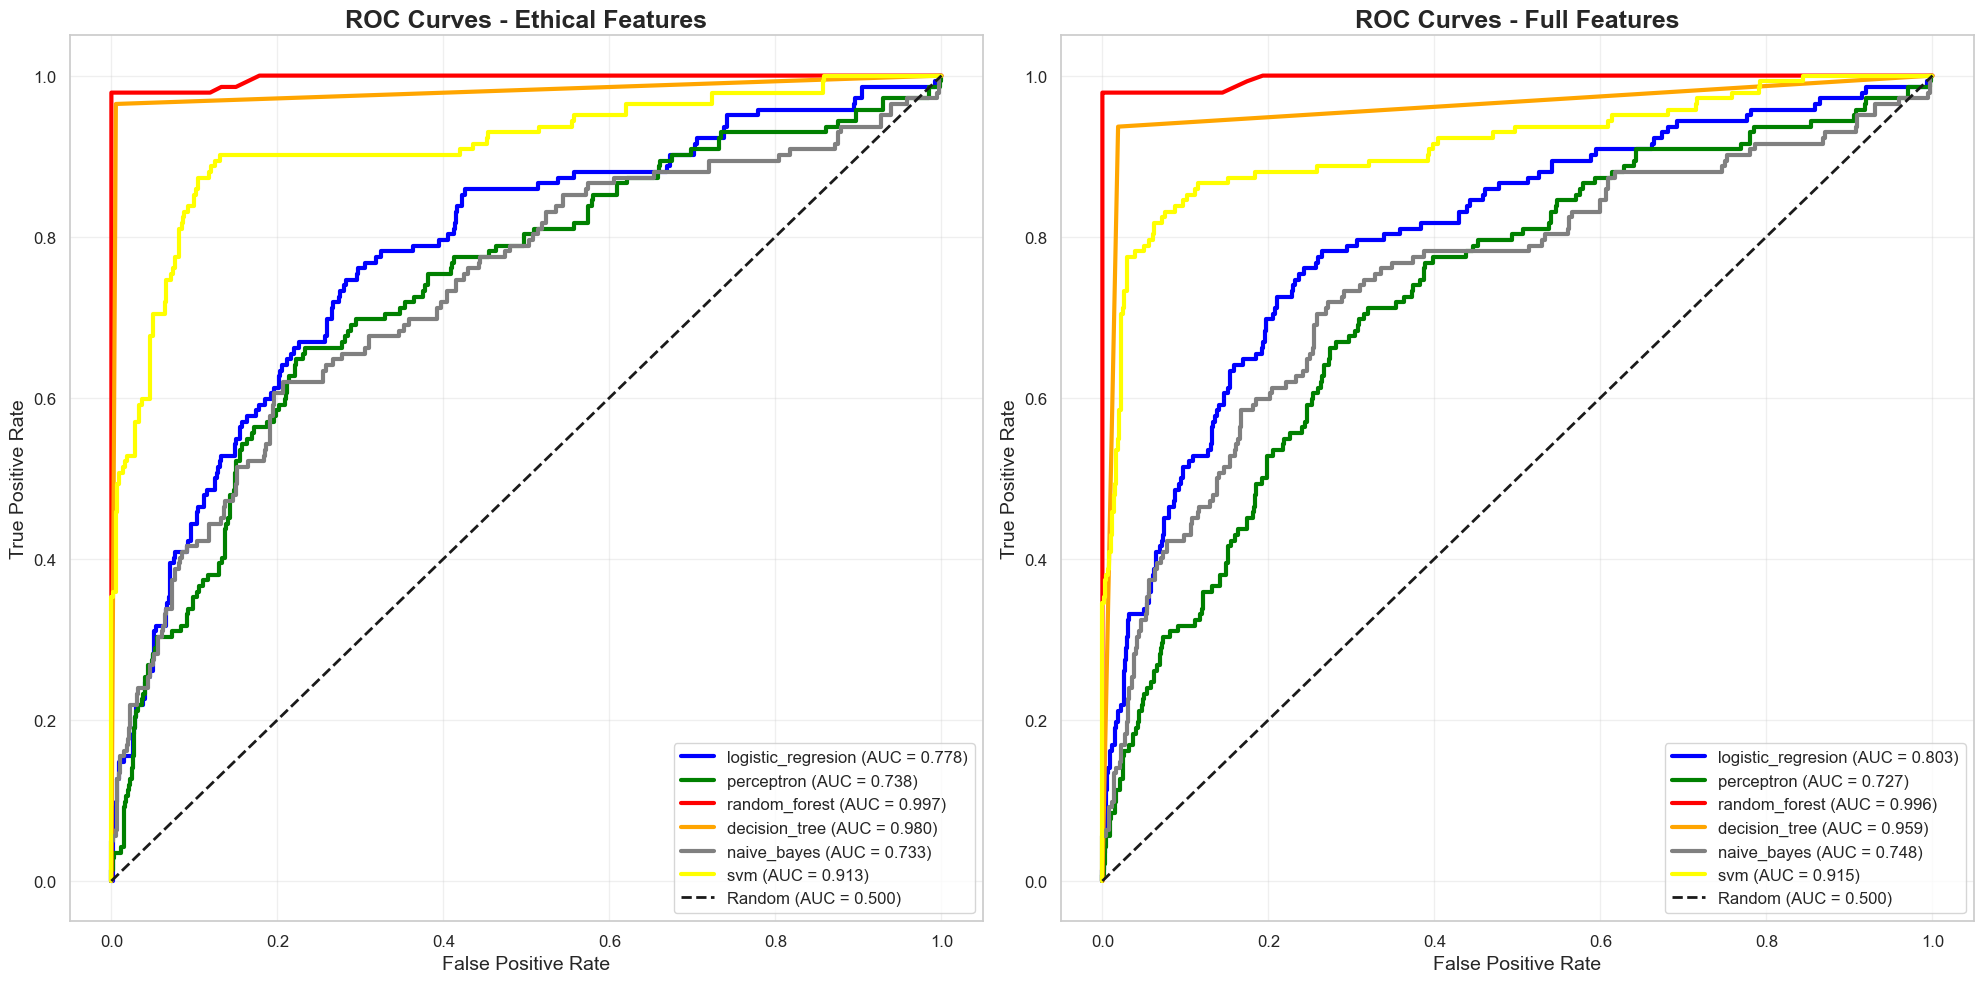

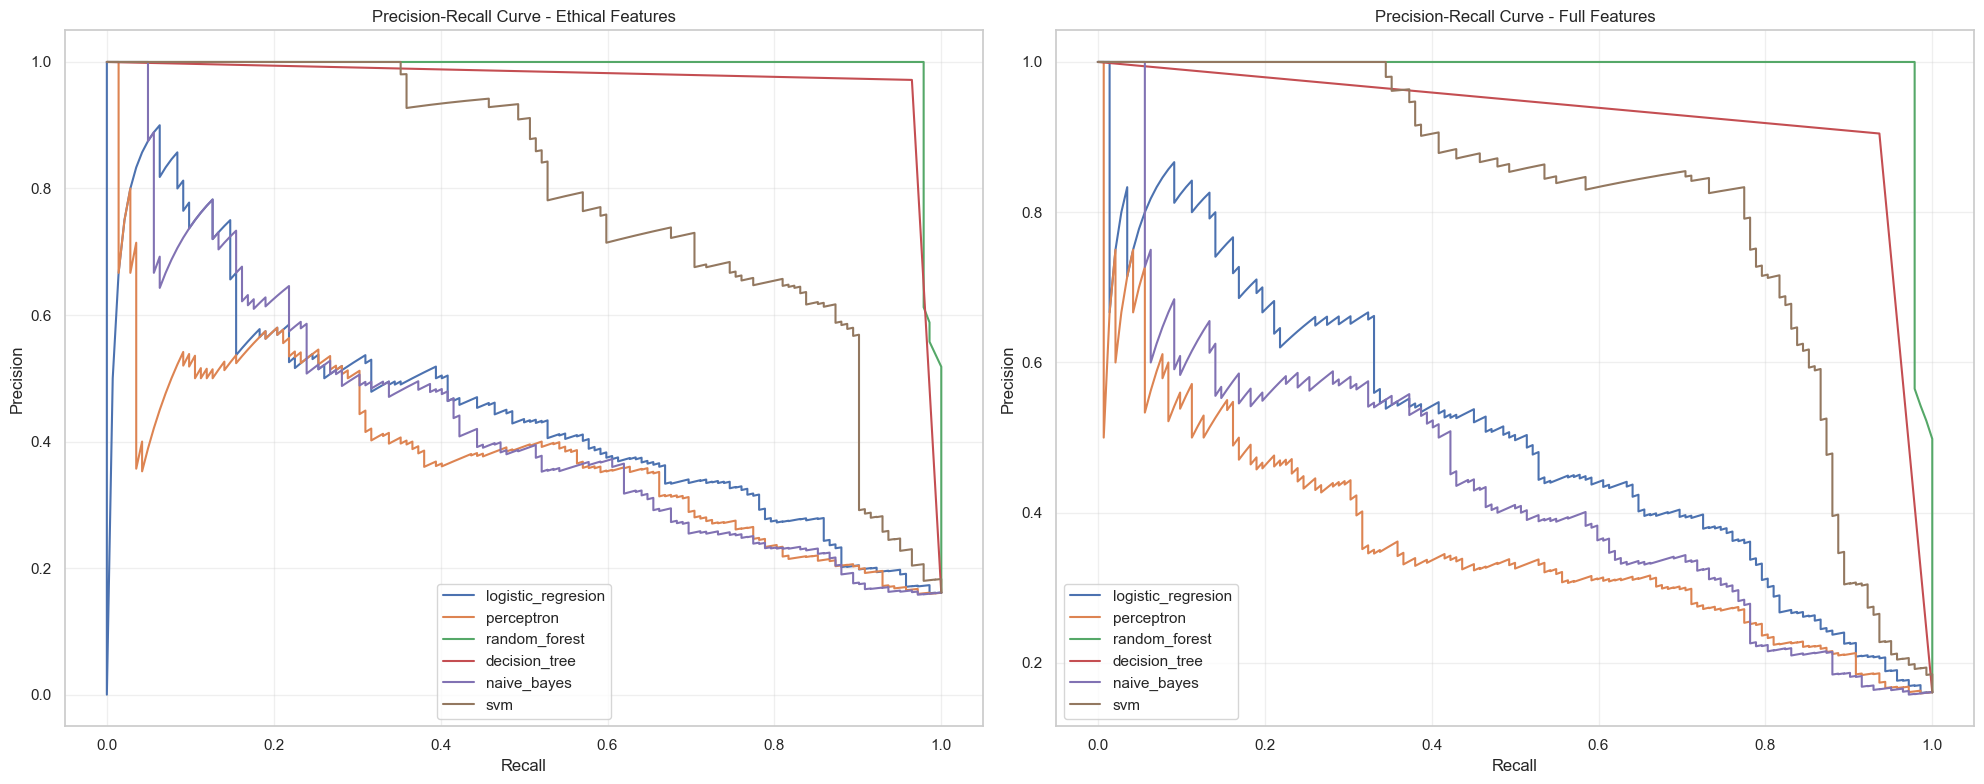

In [14]:

from sklearn.metrics import precision_recall_curve
# Plot ROC curves for all models

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

model_names = ['logistic_regresion', 'perceptron', 'random_forest', 'decision_tree', 'naive_bayes', 'svm']
colors = ['blue', 'green', 'red', 'orange', 'grey', 'yellow']

# Ethical features
for i, name in enumerate(model_names):
    if name in models_eth:
        model = models_eth[name]
        if name == 'perceptron':
            y_proba = model.decision_function(X_test_eth)
        else:
            y_proba = model.predict_proba(X_test_eth)[:, 1]

        fpr, tpr, _ = roc_curve(y_test_eth, y_proba)
        auc = roc_auc_score(y_test_eth, y_proba)
        axes[0].plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})", color=colors[i], linewidth=3)

axes[0].plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.500)', linewidth=2)
axes[0].set_title('ROC Curves - Ethical Features', fontsize=18, fontweight='bold')
axes[0].set_xlabel('False Positive Rate', fontsize=14)
axes[0].set_ylabel('True Positive Rate', fontsize=14)
axes[0].legend(loc='lower right', fontsize=12)
axes[0].tick_params(labelsize=12)
axes[0].grid(True, alpha=0.3)

# Full features
for i, name in enumerate(model_names):
    if name in models_full:
        model = models_full[name]
        if name == 'perceptron':
            y_proba = model.decision_function(X_test_full)
        else:
            y_proba = model.predict_proba(X_test_full)[:, 1]
            
        fpr, tpr, _ = roc_curve(y_test_full, y_proba)
        auc = roc_auc_score(y_test_full, y_proba)
        axes[1].plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})", color=colors[i], linewidth=3)

axes[1].plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.500)', linewidth=2)
axes[1].set_title('ROC Curves - Full Features', fontsize=18, fontweight='bold')
axes[1].set_xlabel('False Positive Rate', fontsize=14)
axes[1].set_ylabel('True Positive Rate', fontsize=14)
axes[1].legend(loc='lower right', fontsize=12)
axes[1].tick_params(labelsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# Drawing Precision-Recall curves for both ethical and full feature sets
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Ethical features
for name in model_names:
    if name in models_eth:
        model = models_eth[name]
        if name == 'perceptron':
            y_proba = model.decision_function(X_test_eth)
        else:
            y_proba = model.predict_proba(X_test_eth)[:, 1]

        precision, recall, _ = precision_recall_curve(y_test_eth, y_proba)
        axes[0].plot(recall, precision, label=name)

axes[0].set_xlabel('Recall')
axes[0].set_ylabel('Precision')
axes[0].set_title('Precision-Recall Curve - Ethical Features')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Full features
for name in model_names:
    if name in models_full:
        model = models_full[name]
        if name == 'perceptron':
            y_proba = model.decision_function(X_test_full)
        else:
            y_proba = model.predict_proba(X_test_full)[:, 1]
        precision, recall, _ = precision_recall_curve(y_test_full, y_proba)
        axes[1].plot(recall, precision, label=name)

axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve - Full Features')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Observation

We analyze the most important factors associated with attrition using feature importance from the Random Forest model.


Top 15 Most Important Features for Attrition Prediction (Ethical Model):


,Feature,Importance,MeanDiff
0,AvgWorkingHours,0.127476,0.548456
1,Age,0.093867,-0.432931
2,TotalWorkingYears,0.083816,-0.462589
3,MonthlyIncome,0.082041,-0.084779
4,YearsAtCompany,0.065239,-0.365457
5,DistanceFromHome,0.059920,-0.026459
6,PercentSalaryHike,0.050414,0.088467
7,YearsWithCurrManager,0.047283,-0.424757
8,EnvironmentSatisfaction,0.042381,-0.276815
9,TrainingTimesLastYear,0.035626,-0.134418


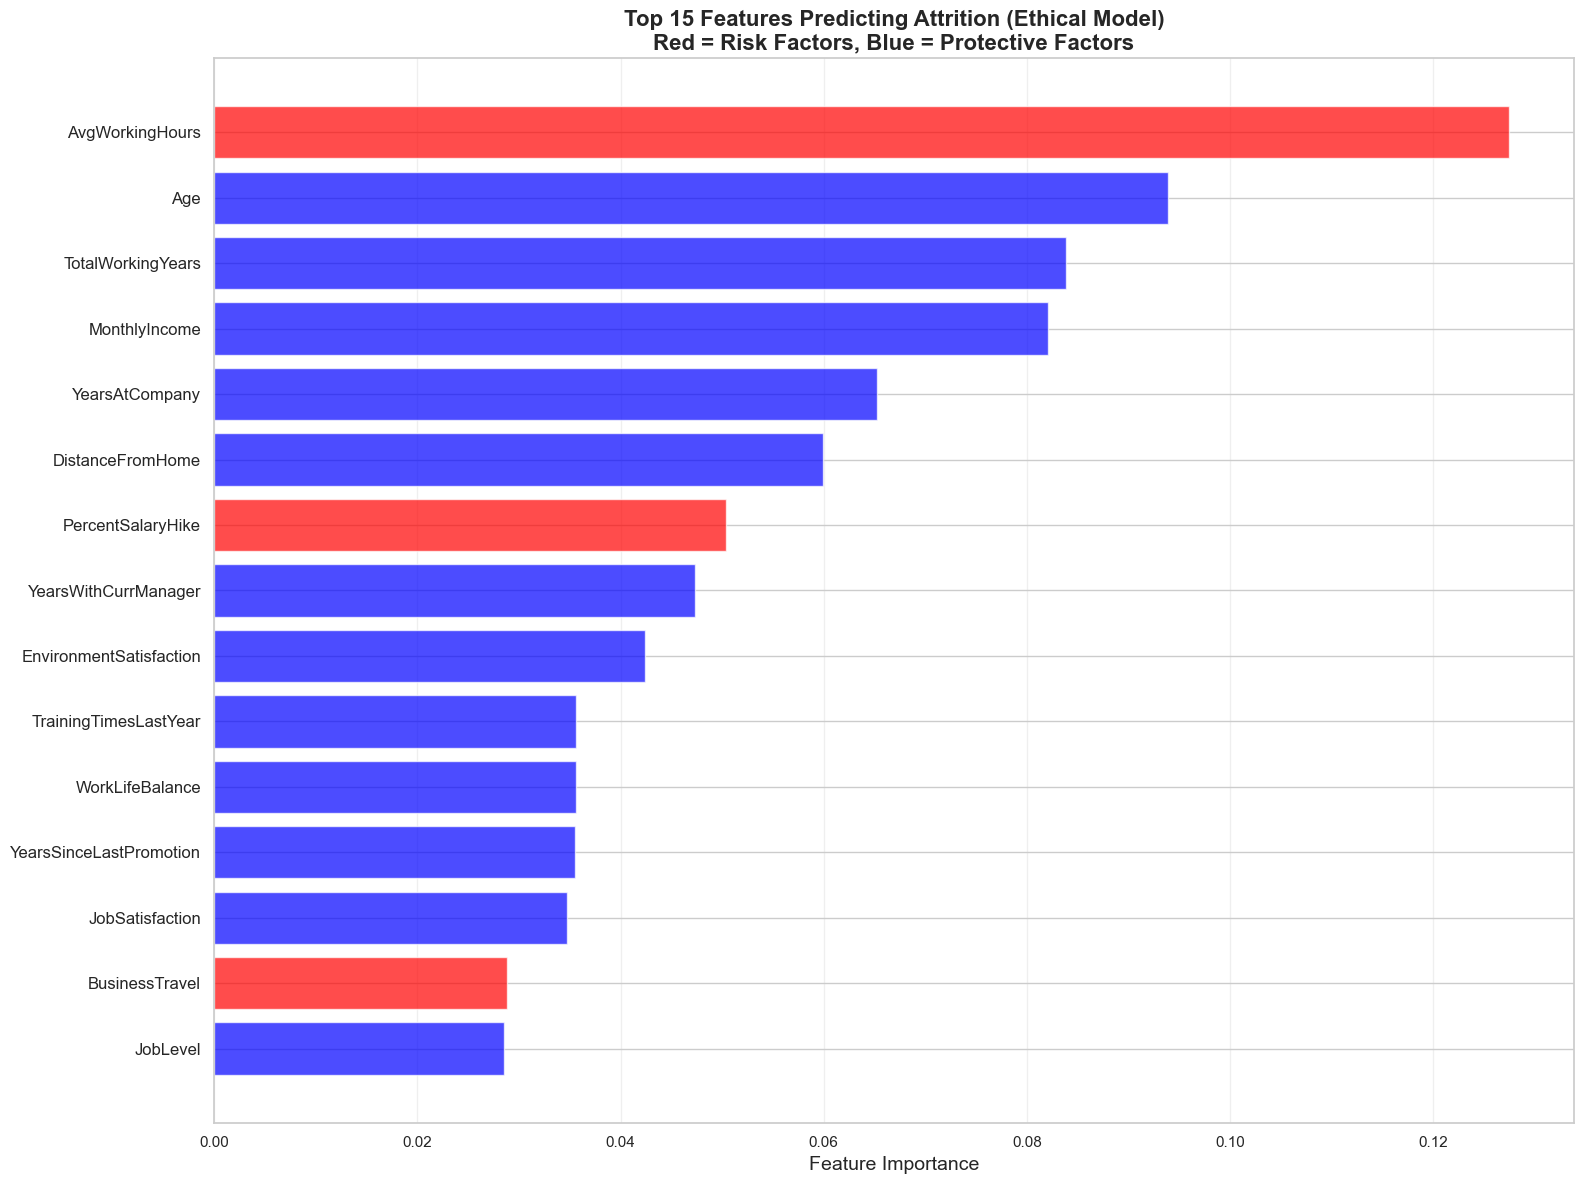

 RED bars: Risk factors - Higher values associated with increased risk of attrition
 BLUE bars: Protective factors - Higher values associated with reduced risk of attrition


In [13]:
# Feature importance analysis using Random Forest
rf_model = models_eth['random_forest']
feature_importance = pd.DataFrame({
    'Feature': X_ethical.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

# Calculate mean difference between leavers (Attrition=1) and stayers (Attrition=0)
# Positive difference = higher for leavers = risk factor (red)
# Negative difference = lower for leavers = protective factor (blue)
group_means = df_ethical.groupby('Attrition').mean(numeric_only=True).T
mean_diff = group_means[1] - group_means[0]  # leavers - stayers

# Merge importance with mean difference
feature_importance = feature_importance.merge(
    mean_diff.reset_index().rename(columns={'index': 'Feature', 0: 'MeanDiff'}),
    on='Feature',
    how='left'
)

# Display top 15 features
print("Top 15 Most Important Features for Attrition Prediction (Ethical Model):")
print("=" * 80)
display(feature_importance.head(15))

# Visualize top features with color coding
plt.figure(figsize=(16, 12))
top_features = feature_importance.head(15)

# Color bars: red for risk factors (positive diff), blue for protective factors (negative diff)
colors = ['red' if diff > 0 else 'blue' for diff in top_features['MeanDiff']]

plt.barh(range(len(top_features)), top_features['Importance'], color=colors, alpha=0.7)
plt.yticks(range(len(top_features)), top_features['Feature'], fontsize=12)
plt.xlabel('Feature Importance', fontsize=14)
plt.title('Top 15 Features Predicting Attrition (Ethical Model)\nRed = Risk Factors, Blue = Protective Factors', 
          fontsize=16, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


print(" RED bars: Risk factors - Higher values associated with increased risk of attrition")
print(" BLUE bars: Protective factors - Higher values associated with reduced risk of attrition")
